In [1]:
import make_bigrams as bgs

/Users/claremariemyers/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
from gensim.models import Word2Vec

In [3]:
from Trend import Trend

In [4]:
import pandas as pd

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_pickled_years(begin_yr, end_yr):
    years_dict = {}
    for year in xrange(begin_yr, end_yr + 1):
        years_dict['df_for_{}'.format(str(year))] = \
            pd.read_pickle('../data/df_for_{}.pkl'.format(str(year)))

    return years_dict

In [6]:
yearly_dfs_x = bgs.load_pickled_years(2009, 2012)

In [7]:
yearly_df_y = bgs.load_pickled_years(2013, 2013)

In [8]:
def load_pickled_models(begin_yr, end_yr):
    models_dict = {}
    for year in xrange(begin_yr, end_yr + 1):
        models_dict['bg_model_for_{}'.format(str(year))] = \
            Word2Vec.load('../models/bg_model_for_{}.txt'.format(str(year)))

    return models_dict
    

In [9]:
bg_models = load_pickled_models(2009, 2012)

In [10]:
best_bigrams = bgs.return_best_bigrams(bg_models)

In [11]:
len(best_bigrams)

4

In [12]:
bg_models.keys()

['bg_model_for_2009',
 'bg_model_for_2012',
 'bg_model_for_2010',
 'bg_model_for_2011']

In [20]:
import numpy as np

class Trend(object):

    def __init__(self, phrase, garment_type=None):
        self.phrase = phrase
        self.type = garment_type


    def plot_by_month(self, df, start_month, start_year, num_months):
        '''
        Creates a plot showing the term frequency of the Trend
        over a given date range, by month, (todo: using a rolling average over 3 months).
        INPUT: dataframe contaiing dates and descriptions,
                starting month and year, number of months to plot
        OUTPUT: matplotlib object
        '''

        month_year_tuples, tfm, tpm = self.get_tfm_tpm(df, 'photo_desc', start_month, start_year, num_months)

        y_axis = tfm*1./tpm

        x_axis = coerce_to_datetime(month_year_tuples)

        plt.plot(x_axis, y_axis, label=self.phrase)

    def differences(self, df, col_name, start_month, start_year, num_months):
        tf_matrix = self.get_tfm_tpm(df, col_name, start_month, start_year, num_months)
        freq_ratio =  tf_matrix[1]*1.0/tf_matrix[2]

        abs_dif_month_over_month = []
        mag_dif_month_over_month = []
        for i in xrange(0, num_months - 12):
            abs_dif_month_over_month.append(freq_ratio[i + 12] - freq_ratio[i])
        for j in xrange(0, num_months - 12):
            mag_dif_month_over_month.append(abs_dif_month_over_month[j]/freq_ratio[j])
        return {'month_yr': tf_matrix[0], 'freq_ratio':freq_ratio, 'abs_dif_m_over_m': abs_dif_month_over_month, \
            'mag_dif_m_over_m': mag_dif_month_over_month}

    def plot_differences(self, df, start_month, start_year, num_months):

        freq_ratio, abs_dif_month_over_month, mag_dif_month_over_month, month_year_tuples = \
               self.differences(df, start_month, start_year, num_months)
        x_axis = coerce_to_datetime(month_year_tuples)
        x_axis = x_axis[12:]

        y_axis = mag_dif_month_over_month

        plt.plot(x_axis, y_axis, label= 'magnitude changes yoy by month for {}'.format(self.phrase))

    def differences_yr(self, df, start_year, end_year):
        #it might be interesting to look at combinations of 2 year pairs
        #this wouldn't get too out of control since we won't be looking at more than a 10-yr time span
        tfy, tpy, years = self.get_tfy_tpy(df, start_year, end_year)
        num_yrs = end_year - start_year
        freq_ratio = np.array(tfy * 1.0)/np.array(tpy)
        abs_difs = []
        mag_difs = []
        for i, y in enumerate(xrange(start_year, end_year)):
            abs_dif = freq_ratio[num_yrs] - freq_ratio[i]
            abs_difs.append(abs_dif)
            mag_dif = abs_dif / freq_ratio[i]
            mag_difs.append(("dif {} over {}".format(end_year, y), mag_dif))

        return abs_difs, mag_difs

    def get_tfm_tpm(self, df, col_name, start_month, start_year, num_months):
        '''
        counts the total number of posts in which a given term appears by month
        and the total posts from that month.
        INPUT: dataframe contaiing dates and descriptions, name of column w/ tokenized descriptions,
                starting month and year, number of months to count
        OUTPUT: mo-yr combo tuples (for plotting/indexing), list of term frequencies
                  per month, list of total posts per month
        '''
        mo = start_month
        yr = start_year

        month_year_tuples = []
        for m in range(num_months):
            #create a list of tuples so we can segment our df
            yr_s = str(yr)
            mo_s = str(mo)
            if len(mo_s) == 1:
                mo_s == '0{}'.format(mo_s)

            month_year_tuples.append((yr, mo, 01))

            if mo % 12 == 0:
                yr += 1
                mo = 1
            else:
                mo += 1


        tf_by_mo = []
        tp_by_mo = []
        rnges = []

        #iterate over months
        for tup in month_year_tuples:

            yr_mask = df.year == tup[0]
            df_yr = df[yr_mask]
            mo_mask = df_yr.month == tup[1]
            df_mo = df_yr[mo_mask]
            segment = df_mo[col_name]
            ct = 0
            total = 0
            for row in segment:
                total += 1
                if self.phrase in row:
                    ct+=1
            tf_by_mo.append(ct)

            #so we don't try to divide by 0
            tp_by_mo.append(total + 1)

        tfm = np.array(tf_by_mo)
        tpm = np.array(tp_by_mo)
        my_tuples = month_year_tuples
        return [my_tuples, tfm, tpm]

    def get_tfy_tpy(self, df, start_year, end_year):
        '''
        counts the total number of posts in which a given term appears over a year
        and the total posts from that year.
        INPUT: dataframe contaiing dates and descriptions, name of column w/ tokenized descriptions,
                starting and ending year
        OUTPUT: list of term frequencies per year, list of total posts per year, list of years
        '''

        tf_by_yr = []
        tp_by_yr = []
        for yr in xrange(start_year, end_year + 1):
            yr_mask = df.year == yr
            df_yr = df[yr_mask]
            segment = df_yr.tokenized_descs
            ct = 0
            total = 0
            for row in segment:
                total += 1
                if self.phrase in row:
                    ct+=1
            tf_by_yr.append(ct)

            #so we don't try to divide by 0
            tp_by_yr.append(total + 1)


        tfy = np.array(tf_by_yr)
        tpy = np.array(tp_by_yr)
        years = xrange(start_year, end_year + 1)
        return tfy, tpy, years


In [22]:
def coerce_to_datetime(series):
    series_2 = []
    for item in series:
        try:
            s = "{}, {}, {}".format(item[0], item[1], item[2])
            series_2.append(s)
        except TypeError:
            series_2.append('2008, 03, 01')
    series_2 = pd.Series(series_2)
    series_3 = pd.to_datetime(series_2)
    return series_3

In [31]:
yearly_df_y.keys()

['df_for_2013']

set(['printed pants', 'patterned pants', 'comfortable wedges', 'sandal wedges', 'colored jeans', 'mustard top', 'zara blazer', 'particular dress', 'guess heels', 'floral shirt', 'chiffon top', 'mint top', 'legged pants', 'floral blouse', 'collar shirt', 'highest heels', 'milk leggings', 'stunning dress', 'wrap dress', 'cotton leggings', 'aztec skirt', 'lace blouse', 'zara shoes', 'mullet skirt', 'striped skirt', 'capri pants', 'chiffon dress', 'riding pants', 'peplum skirt', 'floral pants', 'top dress', 'colored wedges', 'knit sweater', 'velvet shorts', 'chiffon blouse', 'tulle skirt', 'asymmetrical skirt', 'sized handbag', 'peplum top', 'hm pants', 'crochet shorts', 'short jeans', 'suede wedges', 'leopard top', 'chic wedges', 'cropped jumper', 'sneaker wedges', 'higher heels', 'pajama pants', 'hilow dress', 'colored pants', 'floral trousers', 'walking shoes', 'hm trousers', 'gold heels', 'skinny pants', 'campbell shoes', 'disco pants'])
printed pants
[ 0  1  0  0  0  0  0  0  0  0  0 

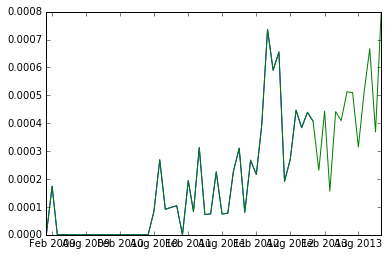



patterned pants
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0
 1 2 2 0 0 0 0 2 0 1 1]


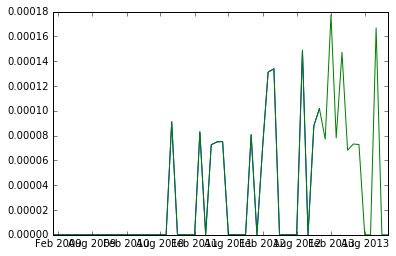



comfortable wedges
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 2 3 0 0 1 1 0 0 0 0 0 0 2 4 0 1 3 1 0 1
 0 2 0 0 0 0 2 2 0 0 0]


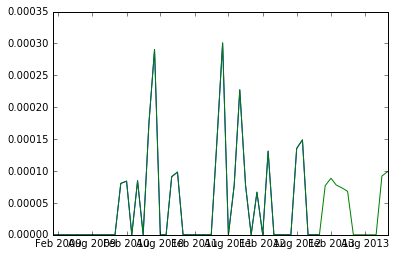



sandal wedges
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 1 0 0 1 0 1 0 1 1 0]


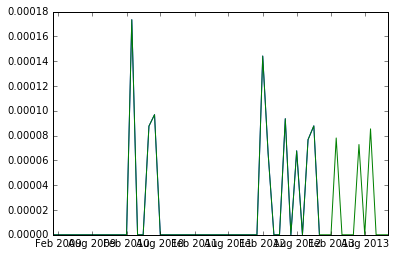



colored jeans
[ 0  0  0  0  1  0  0  0  2  0  0  0  1  1  0  0  0  1  2  2  0  2  0  0  0
  1  1  1  0  0  1  6  0  3  4  2  4  5 14 20  6  0  2  6  6  4  3  1]


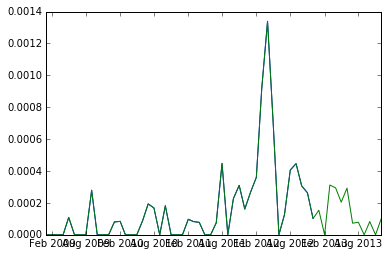



mustard top
[0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 2 1
 0 1 2 0 0 0 0 1 0 0 0]


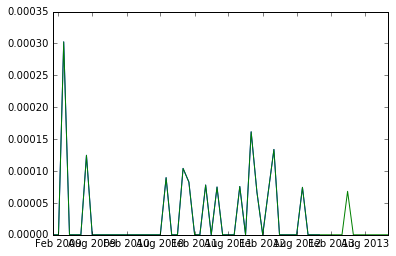



zara blazer
[0 3 1 5 4 2 1 2 2 0 2 1 0 2 0 0 0 0 2 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 1 0 0]


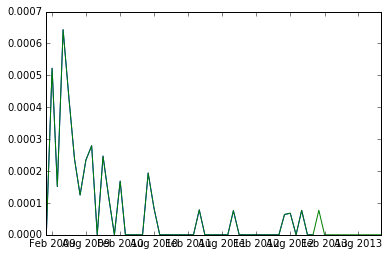



particular dress
[0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 1 0 1 1 2 1 1 0 0 1 0 3 3 1 1 1 0 0
 0 2 3 1 0 1 1 1 1 0 0]


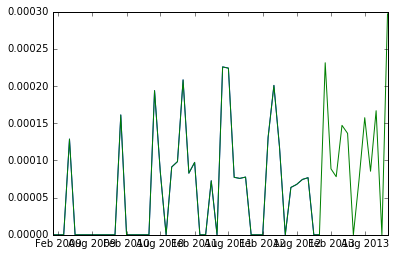



guess heels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


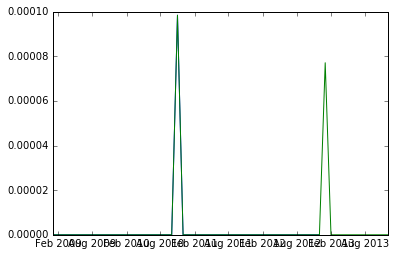



floral shirt
[ 1  1  0  1  2  3  0  2  1  1  2  0  2  4  4  8  1  5  6  2  0  5  1  0  1
  2  4  1  2  3  0  3  8  3  1  4  3  2  6 10  2  5  1  5  2  6  0  2]


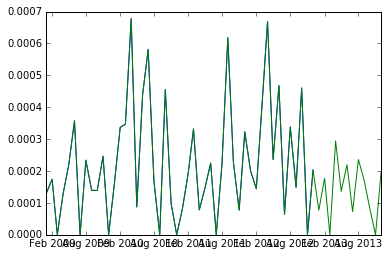



chiffon top
[0 0 0 0 4 1 0 2 1 1 0 0 1 1 2 0 1 1 2 2 3 0 4 1 1 3 3 1 0 1 3 2 3 4 2 5 5
 4 1 2 2 3 9 4 7 6 3 1]


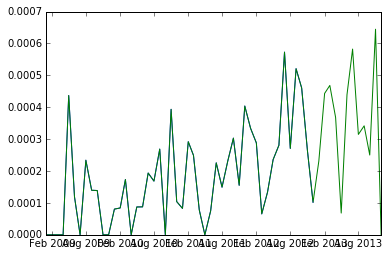



mint top
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0
 0 5 2 1 2 1 1 1 0 0 0]


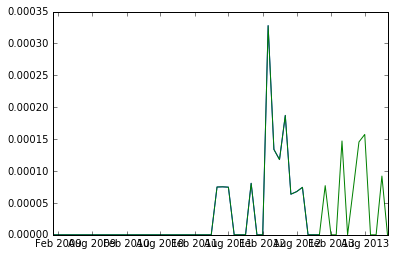



legged pants
[0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 3 2 2 7 4 3 3 1 0 4 3 1 2
 2 2 3 1 1 2 2 0 1 0 0]


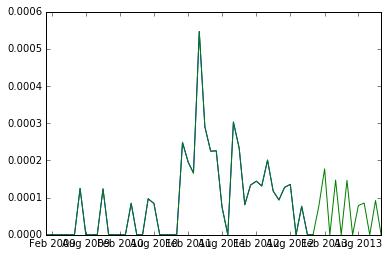



floral blouse
[ 0  0  2  0  3  2  0  0  2  0  2  1  3  6  1  2  2  2  5  2  2  1  3  2  5
  6  1  3  5  2  1  4  5  1  2  4  7  7  3 10  0  3  3  5  6  1  3  1]


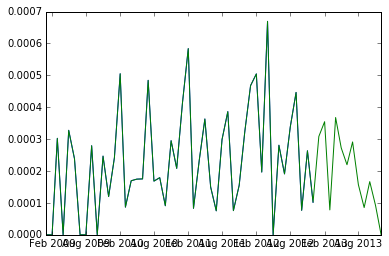



collar shirt
[2 1 0 0 1 1 0 2 0 1 0 1 0 0 0 0 0 2 1 1 0 1 0 0 0 1 0 0 1 1 2 1 2 1 3 0 2
 0 5 5 2 3 2 1 1 5 0 0]


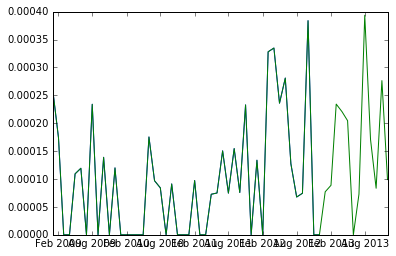



highest heels
[1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 3 1 0 0 1 1 1 1 2 1 0 1 0 0 0 2 1 2 2 0 1 0
 0 1 3 1 0 3 0 0 0 0 0]


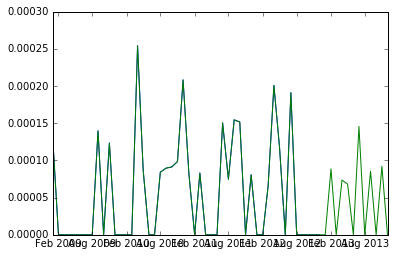



milk leggings
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 2]


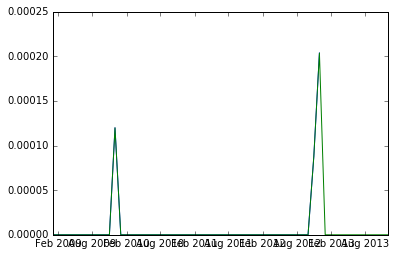



stunning dress
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 2 0 0 1 3 0 3 2 1
 2 2 1 2 3 3 5 3 2 0 1]


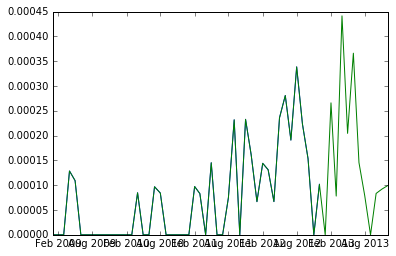



wrap dress
[1 2 0 6 3 3 2 3 2 2 3 0 6 3 3 1 6 4 6 2 5 5 3 2 1 3 1 2 0 1 2 2 3 2 5 1 5
 3 6 5 5 2 3 8 3 9 1 1]


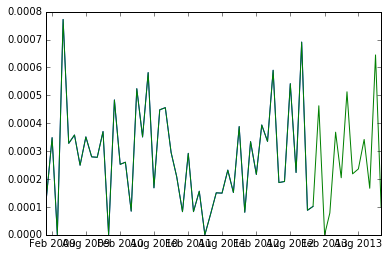



cotton leggings
[0 0 0 0 0 0 1 0 0 1 0 1 2 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 3 5 0 1 0 0 0]


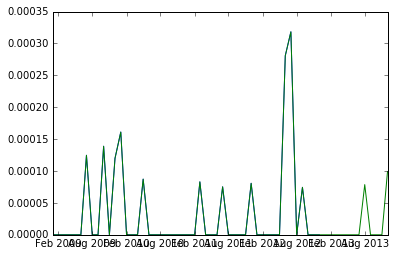



aztec skirt
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 2 0 0 1 0]


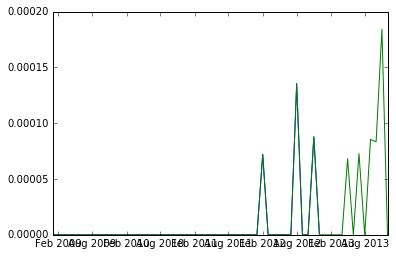



lace blouse
[1 1 1 0 0 0 1 2 0 1 1 0 0 3 1 3 8 2 1 2 3 1 4 3 1 2 0 3 3 2 4 3 4 3 3 7 6
 6 4 2 5 2 4 7 0 6 6 3]


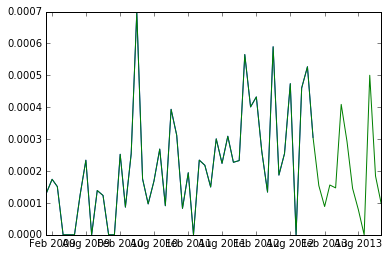



zara shoes
[4 0 2 1 3 1 3 3 1 1 4 0 0 0 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0]


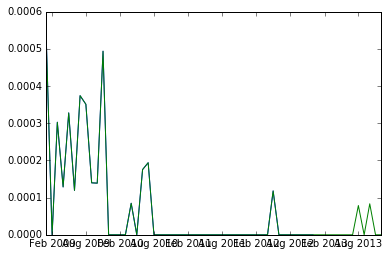



mullet skirt
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  2  3  2  5  7  4 13  3  4  5  4  3  1  2  3]


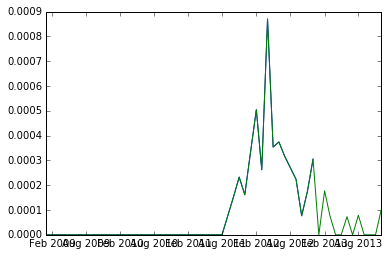



striped skirt
[0 0 0 1 2 1 0 0 0 0 1 0 0 0 2 0 2 5 2 5 1 3 2 1 3 2 2 1 3 2 2 5 6 3 2 2 2
 3 1 2 1 0 4 3 1 2 2 1]


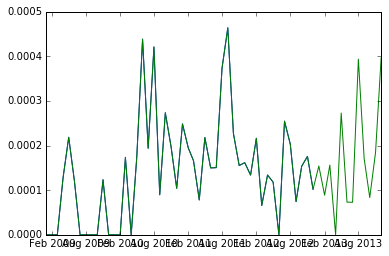



capri pants
[0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 2 1 2 1 0 1 1 1 0 0 0 0 0 2 0 2 2 1 1 0 0
 1 1 1 0 2 1 3 0 0 0 0]


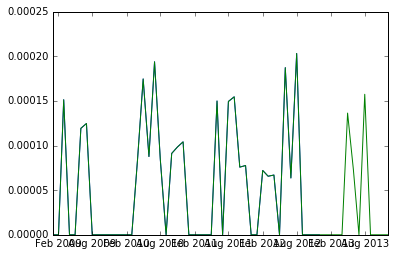



chiffon dress
[ 4  0  2  7  4  4  1  2  2  3  1  2  2  1  5  4  4  5  6  5  3  3  0  2  8
  4  0  2  4  5  2 11  4  7  9  6  6  6  5 14  5  6  9 15  8  9  1  1]


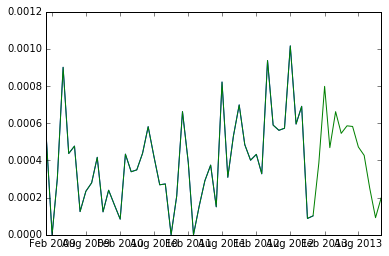



riding pants
[0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 2 1 0 1 1 1 1 3 3 2 4 1 0 2 1 0 2 4 5 2 3
 3 4 2 1 1 1 2 0 1 2 1]


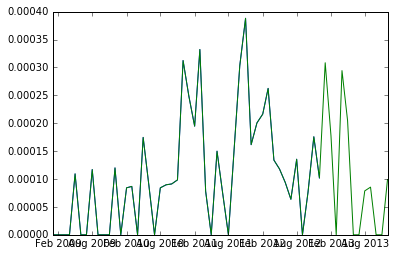



peplum skirt
[ 0  0  0  1  0  1  2  0  0  0  3  2  0  2  0  0  1  1  0  1  0  2  0  0  0
  0  1  0  0  0  0  1  1  1  2  0  0  3  1  6  4  8  6  8 11 10  4  8]


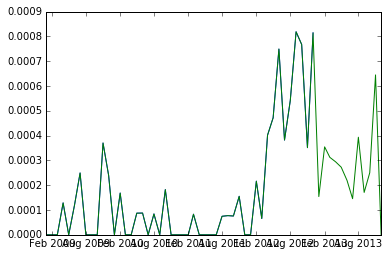



floral pants
[ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1  1  0  1  1  1  2
  2  0  2  2  1  2  2  2  1  3  1  2  2 12 19 13  8  4  9  7  1  2  1]


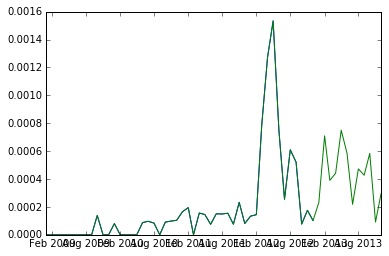



top dress
[2 2 0 0 0 1 3 2 3 0 1 1 1 1 2 0 0 1 4 2 0 1 2 1 3 1 1 1 2 1 1 0 4 1 1 0 1
 3 0 2 0 1 1 3 0 5 2 1]


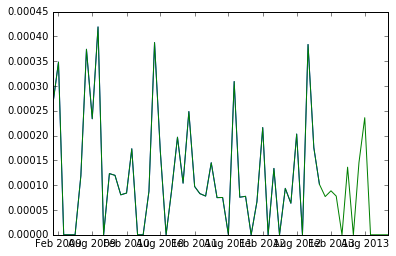



colored wedges
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1
 1 2 0 1 0 0 2 0 0 1 0]


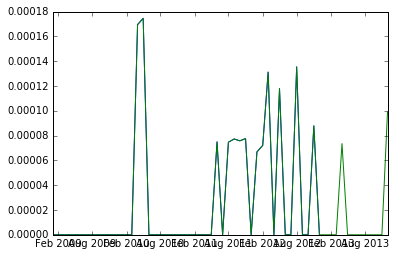



knit sweater
[ 5  0  0  3  3  0  2  2  0  6  6  4  7  6  6  3  2  1  2  0  4 14 16 16 14
  7  7  5  4  7  2  9  9 15 28 25 25 10 12 10  7  4  5  6  8 22 17 27]


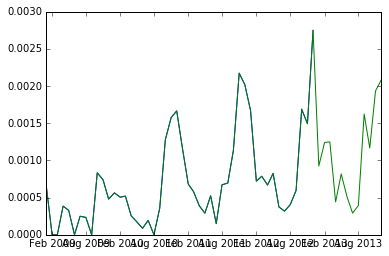



velvet shorts
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 3 2
 1 1 0 2 0 0 0 0 1 0 1]


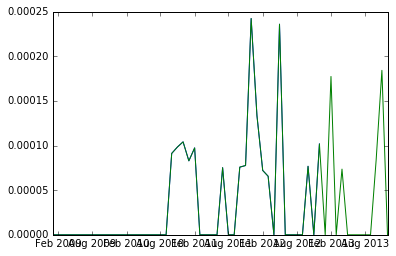



chiffon blouse
[ 0  1  1  4  1  0  2  0  1  1  2  0  0  0  0  1  0  0  2  1  1  1  1  1  0
  3  2  1  2  3  4  6  8  4  4  5 11 11  7  7  4  7  1  5  4  5  5  4]


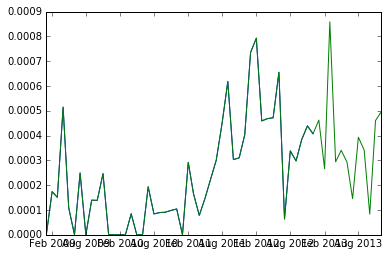



tulle skirt
[3 0 0 1 2 0 0 1 5 1 1 8 5 2 4 0 3 5 2 1 2 2 4 5 3 1 3 5 4 3 7 2 9 6 3 1 2
 2 4 5 0 4 6 3 2 8 5 8]


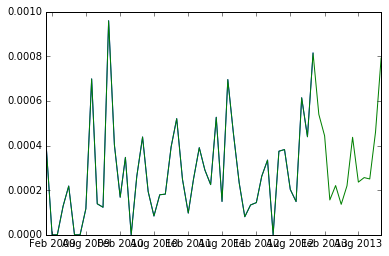



asymmetrical skirt
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 4 2 1 2 3
 7 7 6 6 3 5 5 1 1 1 1]


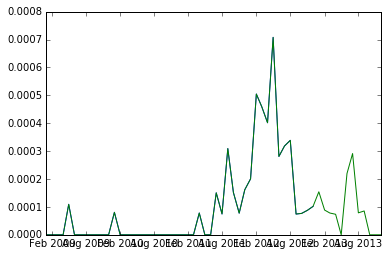



sized handbag
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 3 2 0 0 0 0 2 0]


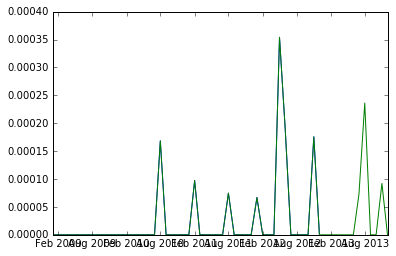



peplum top
[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  3  2  7  4  3 21 16 30 32 20 13]


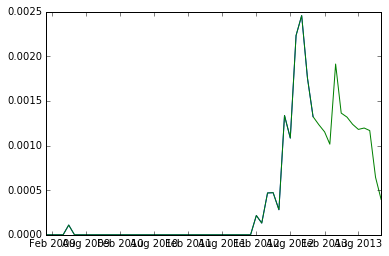



hm pants
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


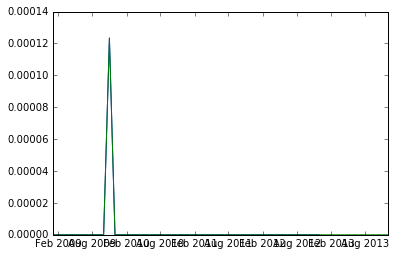



crochet shorts
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 3 2 1 0 3 1 0
 2 3 4 1 1 8 9 3 0 1 1]


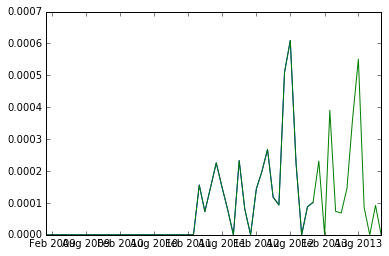



short jeans
[0 0 3 1 8 7 4 3 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 2 1 1 0 0 0 2 0 0
 1 2 0 0 0 0 3 2 0 1 0]


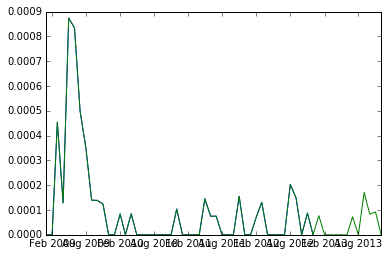



suede wedges
[1 0 1 0 1 0 2 0 0 1 0 0 0 2 2 1 0 3 4 1 1 2 1 5 4 2 2 0 1 1 3 2 2 3 2 5 4
 1 3 2 2 2 4 3 1 1 0 1]


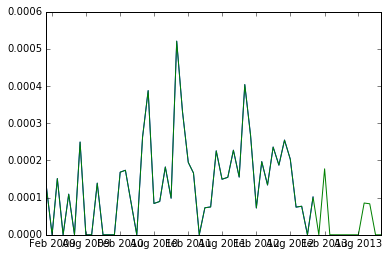



leopard top
[0 0 0 0 0 1 1 2 1 2 1 1 1 1 0 0 1 1 0 0 2 3 2 2 1 0 6 1 0 1 1 5 2 1 0 4 0
 3 1 1 0 1 5 5 0 0 0 0]


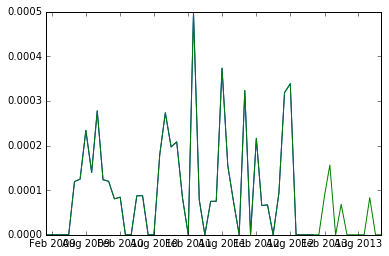



chic wedges
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 1 0 0 0 1 0 1 0 0]


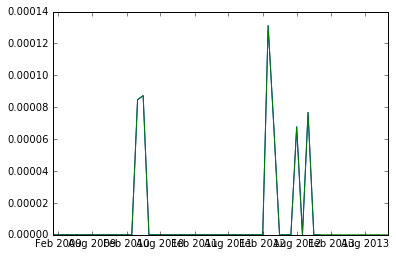



cropped jumper
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 2 2 0 0 0 0 0
 1 0 0 0 0 1 0 2 0 0 1]


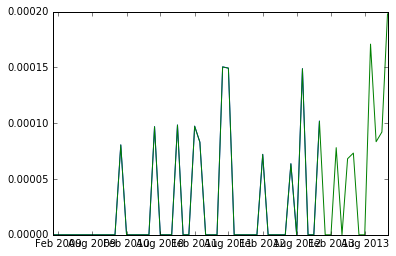



sneaker wedges
[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  0  0  1  2  4 11  2  3]


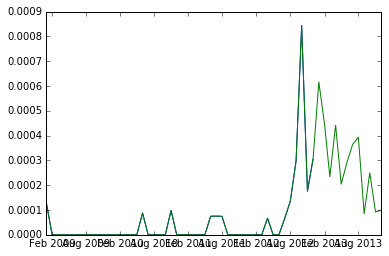



higher heels
[0 0 1 0 1 0 1 0 2 1 0 0 1 2 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0
 0 1 3 0 0 1 0 0 0 0 1]


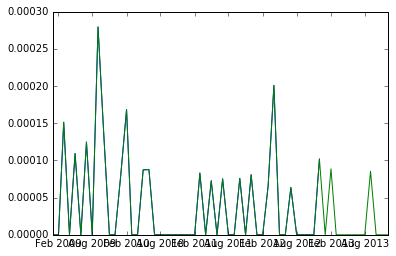



pajama pants
[0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 2 1 2 1 1 0 1 2 0 3 0 0 0 1 1 0 1 1 3 1 2 0
 1 4 4 2 4 2 0 2 2 0 0]


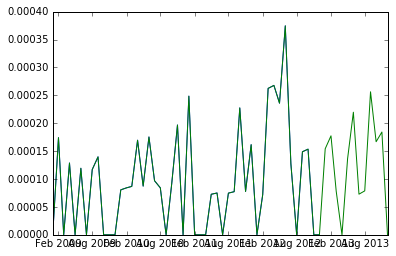



hilow dress
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


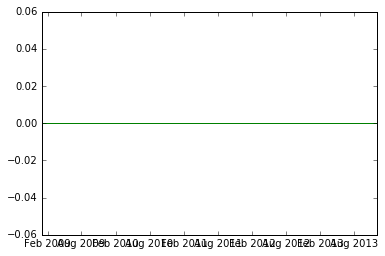



colored pants
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 2 1 1 2 5 6 5 2 3 7
 4 9 1 2 0 9 2 2 6 6 2]


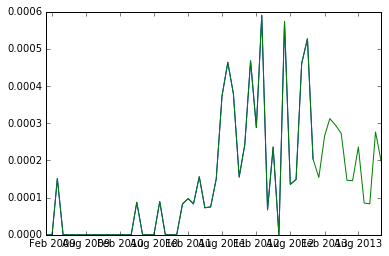



floral trousers
[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 3 3 2 0 1 0 1 1 0 1]


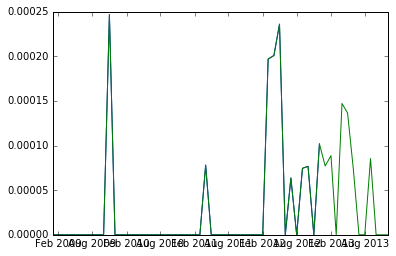



walking shoes
[0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 1 0 0 1 1 2 1
 0 0 1 1 0 2 0 1 0 0 0]


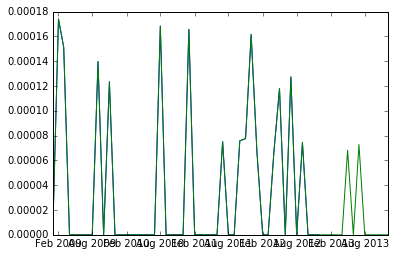



hm trousers
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


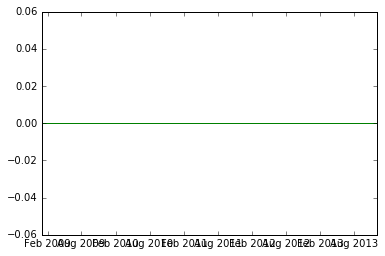



gold heels
[1 0 1 0 1 0 4 2 3 0 1 2 2 2 0 1 0 1 1 3 1 0 1 0 2 0 0 1 0 0 1 1 0 3 0 0 1
 2 0 2 1 1 1 1 3 0 1 1]


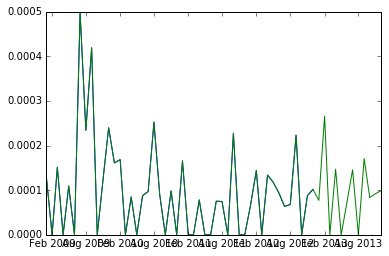



skinny pants
[ 4  2  7  4  4  3  3  1  1  4  6  4  6  4  3  6  1  1  1  1  6  4  3  0  2
  3  2  2  2  1  2  2  7  1 10  2  6  5  9  8  3  3  3  1 11  6  5  3]


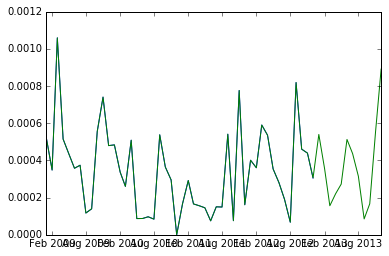



campbell shoes
[0 0 0 0 0 1 3 0 0 0 0 0 1 0 2 1 0 0 1 0 2 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0]


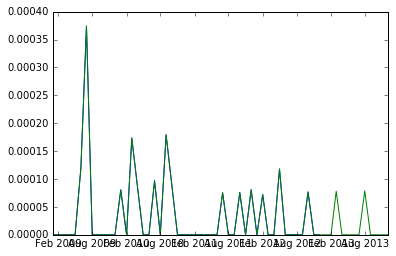



disco pants
[0 3 1 2 1 0 1 2 0 0 0 2 0 0 1 1 0 1 0 2 0 0 1 0 0 0 3 0 2 0 0 1 1 0 1 1 1
 0 2 3 2 0 2 4 2 3 4 1]


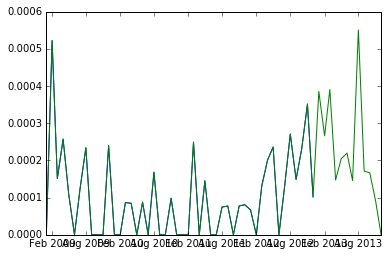

In [33]:
x_slices_to_combine = [v for k, v in yearly_dfs_x.iteritems()]
X_slice_df = pd.concat(x_slices_to_combine)


union_2009_2011 = set(best_bigrams['sim_bigrams_2009'] + \
    best_bigrams['sim_bigrams_2010'] + best_bigrams['sim_bigrams_2011'])
only_2012 = set(best_bigrams['sim_bigrams_2012']) - union_2009_2011
print only_2012

trend_dict_2012 = {}
for trend in only_2012:
    trend_dict_2012[trend] = Trend(trend)
    print trend
    print trend_dict_2012[trend].get_tfm_tpm(X_slice_df, 'photo_desc', 1, 2009, 48)[1]
    trend_dict_2012[trend].plot_by_month(X_slice_df, 1, 2009, 48)

    trend_dict_2012[trend].plot_by_month(pd.concat([X_slice_df, yearly_df_y['df_for_2013']]), 1, 2009, 60)
    plt.show()
    print '\n'
    

In [34]:
from gensim.models import Phrases

In [35]:
bigrams = Phrases(X_slice_df.tokenized_descs)

In [53]:
basic_garments = ['dress', 'shirt', 'skirt', 'pants', 'shoes', 'bag']

In [72]:
phrased_bgs = []

for sentence in yearly_dfs_x['df_for_2012'].tokenized_descs:
    bg_sent = bigrams[sentence]
    for word in bg_sent:
        if '_' in word:
            two_words = word.split('_')
            if two_words[1] in basic_garments:
                phrased_bgs.append(word)
                

In [76]:
master_model = Word2Vec.load('../models/model_2009_2012.txt')
sentences = yearly_dfs_x['df_for_2012'].tokenized_descs


yearly_dfs_x['df_for_2012']['bigramified'] = bgs.bigrams_for_all_garments(sentences, master_model)

In [77]:
my_model_bgs = []

for sentence in yearly_dfs_x['df_for_2012'].bigramified:

    for word in sentence:
        if '_' in word:
            two_words = word.split('_')
            if two_words[1] in basic_garments:
                my_model_bgs.append(word)

In [78]:
print Counter(my_model_bgs)

Counter({'maxi_dress': 596, 'maxi_skirt': 508, 'black_dress': 493, 'pencil_skirt': 388, 'mini_dress': 307, 'vintage_dress': 273, 'floral_dress': 264, 'lace_dress': 251, 'pleated_skirt': 237, 'denim_shirt': 232, 'leather_skirt': 222, 'print_dress': 212, 'summer_dress': 191, 'mini_skirt': 191, 'white_shirt': 162, 'white_dress': 159, 'party_dress': 154, 'new_dress': 152, 'leather_pants': 150, 'red_dress': 125, 'new_shoes': 123, 'black_skirt': 120, 'small_pants': 118, 'shoulder_bag': 117, 'shift_dress': 108, 'print_skirt': 104, 'floral_skirt': 104, 'floral_pants': 103, 'beautiful_dress': 102, 'wedding_dress': 102, 'shirt_dress': 101, 'sweater_dress': 94, 'harem_pants': 91, 'lovely_dress': 90, 'blue_dress': 89, 'chiffon_dress': 88, 'full_skirt': 88, 'perfect_dress': 88, 'lace_skirt': 86, 'cocktail_dress': 86, 'chiffon_skirt': 86, 'long_skirt': 86, 'circle_skirt': 85, 'favorite_dress': 85, 'pink_dress': 85, 'plaid_shirt': 83, 'prom_dress': 80, 'amazing_dress': 80, 'black_pants': 79, 'chambra

In [79]:
from collections import Counter


In [80]:
print Counter(phrased_bgs)

Counter({u'maxi_dress': 587, u'maxi_skirt': 465, u'pencil_skirt': 382, u'pleated_skirt': 236, u'denim_shirt': 230, u'mini_skirt': 173, u'shoulder_bag': 125, u'shift_dress': 103, u'tote_bag': 93, u'harem_pants': 91, u'plaid_shirt': 83, u'chambray_shirt': 80, u'bodycon_dress': 76, u'flat_shoes': 73, u'circle_skirt': 67, u'palazzo_pants': 66, u't_shirt': 66, u'midi_skirt': 63, u'striped_shirt': 57, u'skater_dress': 55, u'mullet_skirt': 54, u'collared_shirt': 53, u'tulle_skirt': 51, u'highlow_skirt': 49, u'tube_dress': 46, u'bandage_skirt': 44, u'aline_skirt': 44, u'skater_skirt': 43, u'bodycon_skirt': 43, u'disco_pants': 38, u'chanel_bag': 37, u'messenger_bag': 36, u'tutu_skirt': 34, u'satchel_bag': 33, u'gladiator_shoes': 32, u'oxford_shoes': 31, u'dust_bag': 28, u'highwaisted_skirt': 27, u'pajama_pants': 26, u'mens_shirt': 26, u'highwaisted_pants': 25, u'riding_pants': 25, u'crossbody_bag': 21, u'cargo_pants': 21, u'sling_bag': 21, u'flannel_shirt': 19, u'coach_bag': 19, u'baggy_pants':

In [68]:
sling_bag = Trend("sling bag")

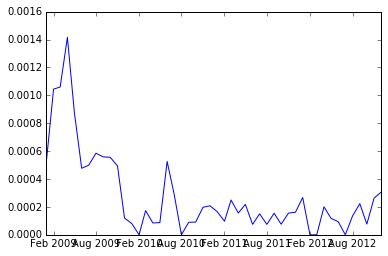

In [69]:
sling_bag.plot_by_month(X_slice_df, 1, 2009, 48)

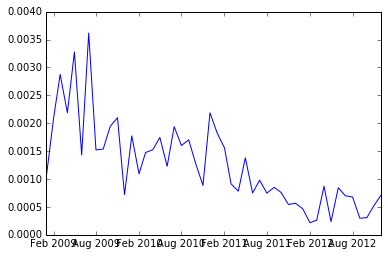

In [70]:
harem_pants = Trend("harem pants")
harem_pants.plot_by_month(X_slice_df, 1, 2009, 48)

In [81]:
def collect_similar(word, model, n_output):
    '''
    INPUT: word = a base vocabulary word
        model = a trained word2vec model (or path in the form Word2Vec.open('model_path'))
        n_output = the number of similar words to collect
                    the root word will also be included in this list

    RETURNS: a list of words
    '''

    most_sim = model.most_similar(word, topn=n_output)
    most_sim_list = [item[0] for item in most_sim]
    most_sim_list.append(word)

    return most_sim_list

In [86]:
all_sim = []
for g in basic_garments:
    all_sim += collect_similar(g, master_model, 15)

In [87]:
print all_sim

['skirt', 'romper', 'jumpsuit', 'tunic', 'blouse', 'playsuit', 'swimsuit', 'sundress', 'minidress', 'leotard', 'shirtdress', 'top', 'blazer', 'petticoat', 'jumper', 'dress', 'tshirt', 'blouse', 'top', 'tee', 'sweatshirt', 'blazer', 'hoodie', 'sweater', 'cardigan', 'jumper', 'polo', 'shirtdress', 'tunic', 'vest', 'tanktop', 'shirt', 'dress', 'romper', 'tunic', 'miniskirt', 'leotard', 'jumpsuit', 'shirtdress', 'corset', 'blouse', 'petticoat', 'bustier', 'bodysuit', 'minidress', 'blazer', 'playsuit', 'skirt', 'trousers', 'shorts', 'jeggings', 'jeans', 'pant', 'skinnies', 'leggings', 'cargos', 'bottoms', 'overalls', 'chinos', 'capris', 'slacks', 'cords', 'cutoffs', 'pants', 'wedges', 'oxfords', 'sandals', 'heels', 'clogs', 'loafers', 'platforms', 'boots', 'booties', 'moccasins', 'pumps', 'brogues', 'sneakers', 'flats', 'gladiators', 'shoes', 'purse', 'handbag', 'satchel', 'clutch', 'backpack', 'tote', 'messenger', 'hobo', 'briefcase', 'crossbody', 'pouch', 'lv', 'coach', 'dooney', 'bourke'

In [88]:
len(all_sim)

96

In [89]:
len(set(all_sim))

78